In [1]:
import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.rates
import hpa.cluster
import hpa.util

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from sklearn import cluster as cl
from scipy.optimize import curve_fit

In [3]:
plt.style.use('default')
plt.style.use('/localscratch/zippoema/md_plots/rates_plot.mplstyle')

In [4]:
path_200 = '/localscratch/zippoema/project_ness/simulations/200-tdp43_CAL3/'
path_ss = '/localscratch/zippoema/project_ness/simulations/search_steadystate/'
path_work = '/localscratch/zippoema/working_dir/'

## Compute Gamma ( s(c0_{in}) and s(c0_{out}) )

In [22]:
def compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2):
    tr = gsd.hoomd.open(input_file+'dump.gsd', 'r')
    c = np.loadtxt(input_file+'contacts.txt')
    
    c_p = c[c[:, 2] == 1]
    c_dp = c[c[:, 2] == -1]
    times_p = np.rint(c_p[:,0]/200000).astype(int)
    times_dp = np.rint(c_dp[:,0]/200000).astype(int)
    
    in_out = np.zeros((len(tr)+1,len(ser_i)))
    frame = gsd.hoomd.open(input_file+'start.gsd', 'r')[0]
    positions = frame.particles.position
    type_ids = frame.particles.typeid[:30800]
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    in_out[0] = labels[ser_i]==condensate_idx
    
    for i, frame in enumerate(tr):
        positions = frame.particles.position
        type_ids = frame.particles.typeid[:30800]
        db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
        labels = db.labels_
        values, counts = np.unique(labels[:30800], return_counts=True)
        condensate_idx = values[np.argmax(counts)]
        in_out[i+1] = labels[ser_i]==condensate_idx
    
    count_in_p = 0
    count_out_p = 0
    for i, tt in enumerate(times_p):
        ser_index = np.where(ser_i==c_p[i,1])[0][0]
        count_in_p += int(in_out[tt,ser_index])
        if not in_out[tt,ser_index]:
            count_out_p +=1
            print(i, tt, c_p[i,1], c_p[i,5])
    
    count_in_dp = 0
    count_out_dp = 0
    for i, tt in enumerate(times_dp):
        ser_index = np.where(ser_i==c_dp[i,1])[0][0]
        count_in_dp += int(in_out[tt,ser_index])
        if not in_out[tt,ser_index]:
            count_out_dp +=1
    
    return count_in_dp-count_in_p, count_out_dp-count_out_p

In [23]:
ser_i = np.array([266, 273, 292, 305, 317, 332, 333, 342, 347, 350, 369, 373, 375, 377, 379, 387, 389, 393, 395, 403, 404, 407, 409, 410])-260-1 
ser_i = np.array([ ser_i+154*j for j in range(200) ]).flatten()



In [24]:
delta_n_in = 0
delta_n_out = 0
nsims = 30
for s in tqdm(range(1,nsims+1)):
    input_file = path_work+f'no_driving_slab/compute_gamma_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim{s}_sh_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_'
    tmp_in, tmp_out = compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2)
    delta_n_in += tmp_in
    delta_n_out += tmp_out
delta_n_in /= nsims
delta_n_out /= nsims

  0%|                                                    | 0/30 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [13]:
delta_n_in, delta_n_out

(-14.833333333333334, 2.4)

## Compute diffusion coefficient in dilute

In [8]:
dtimes, msd = hpa.util.compute_msd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [24]:
def linear(x,a,b):
    return x*a+b

In [29]:
popt, pcov = curve_fit(linear, dtimes[:30],msd[:30])

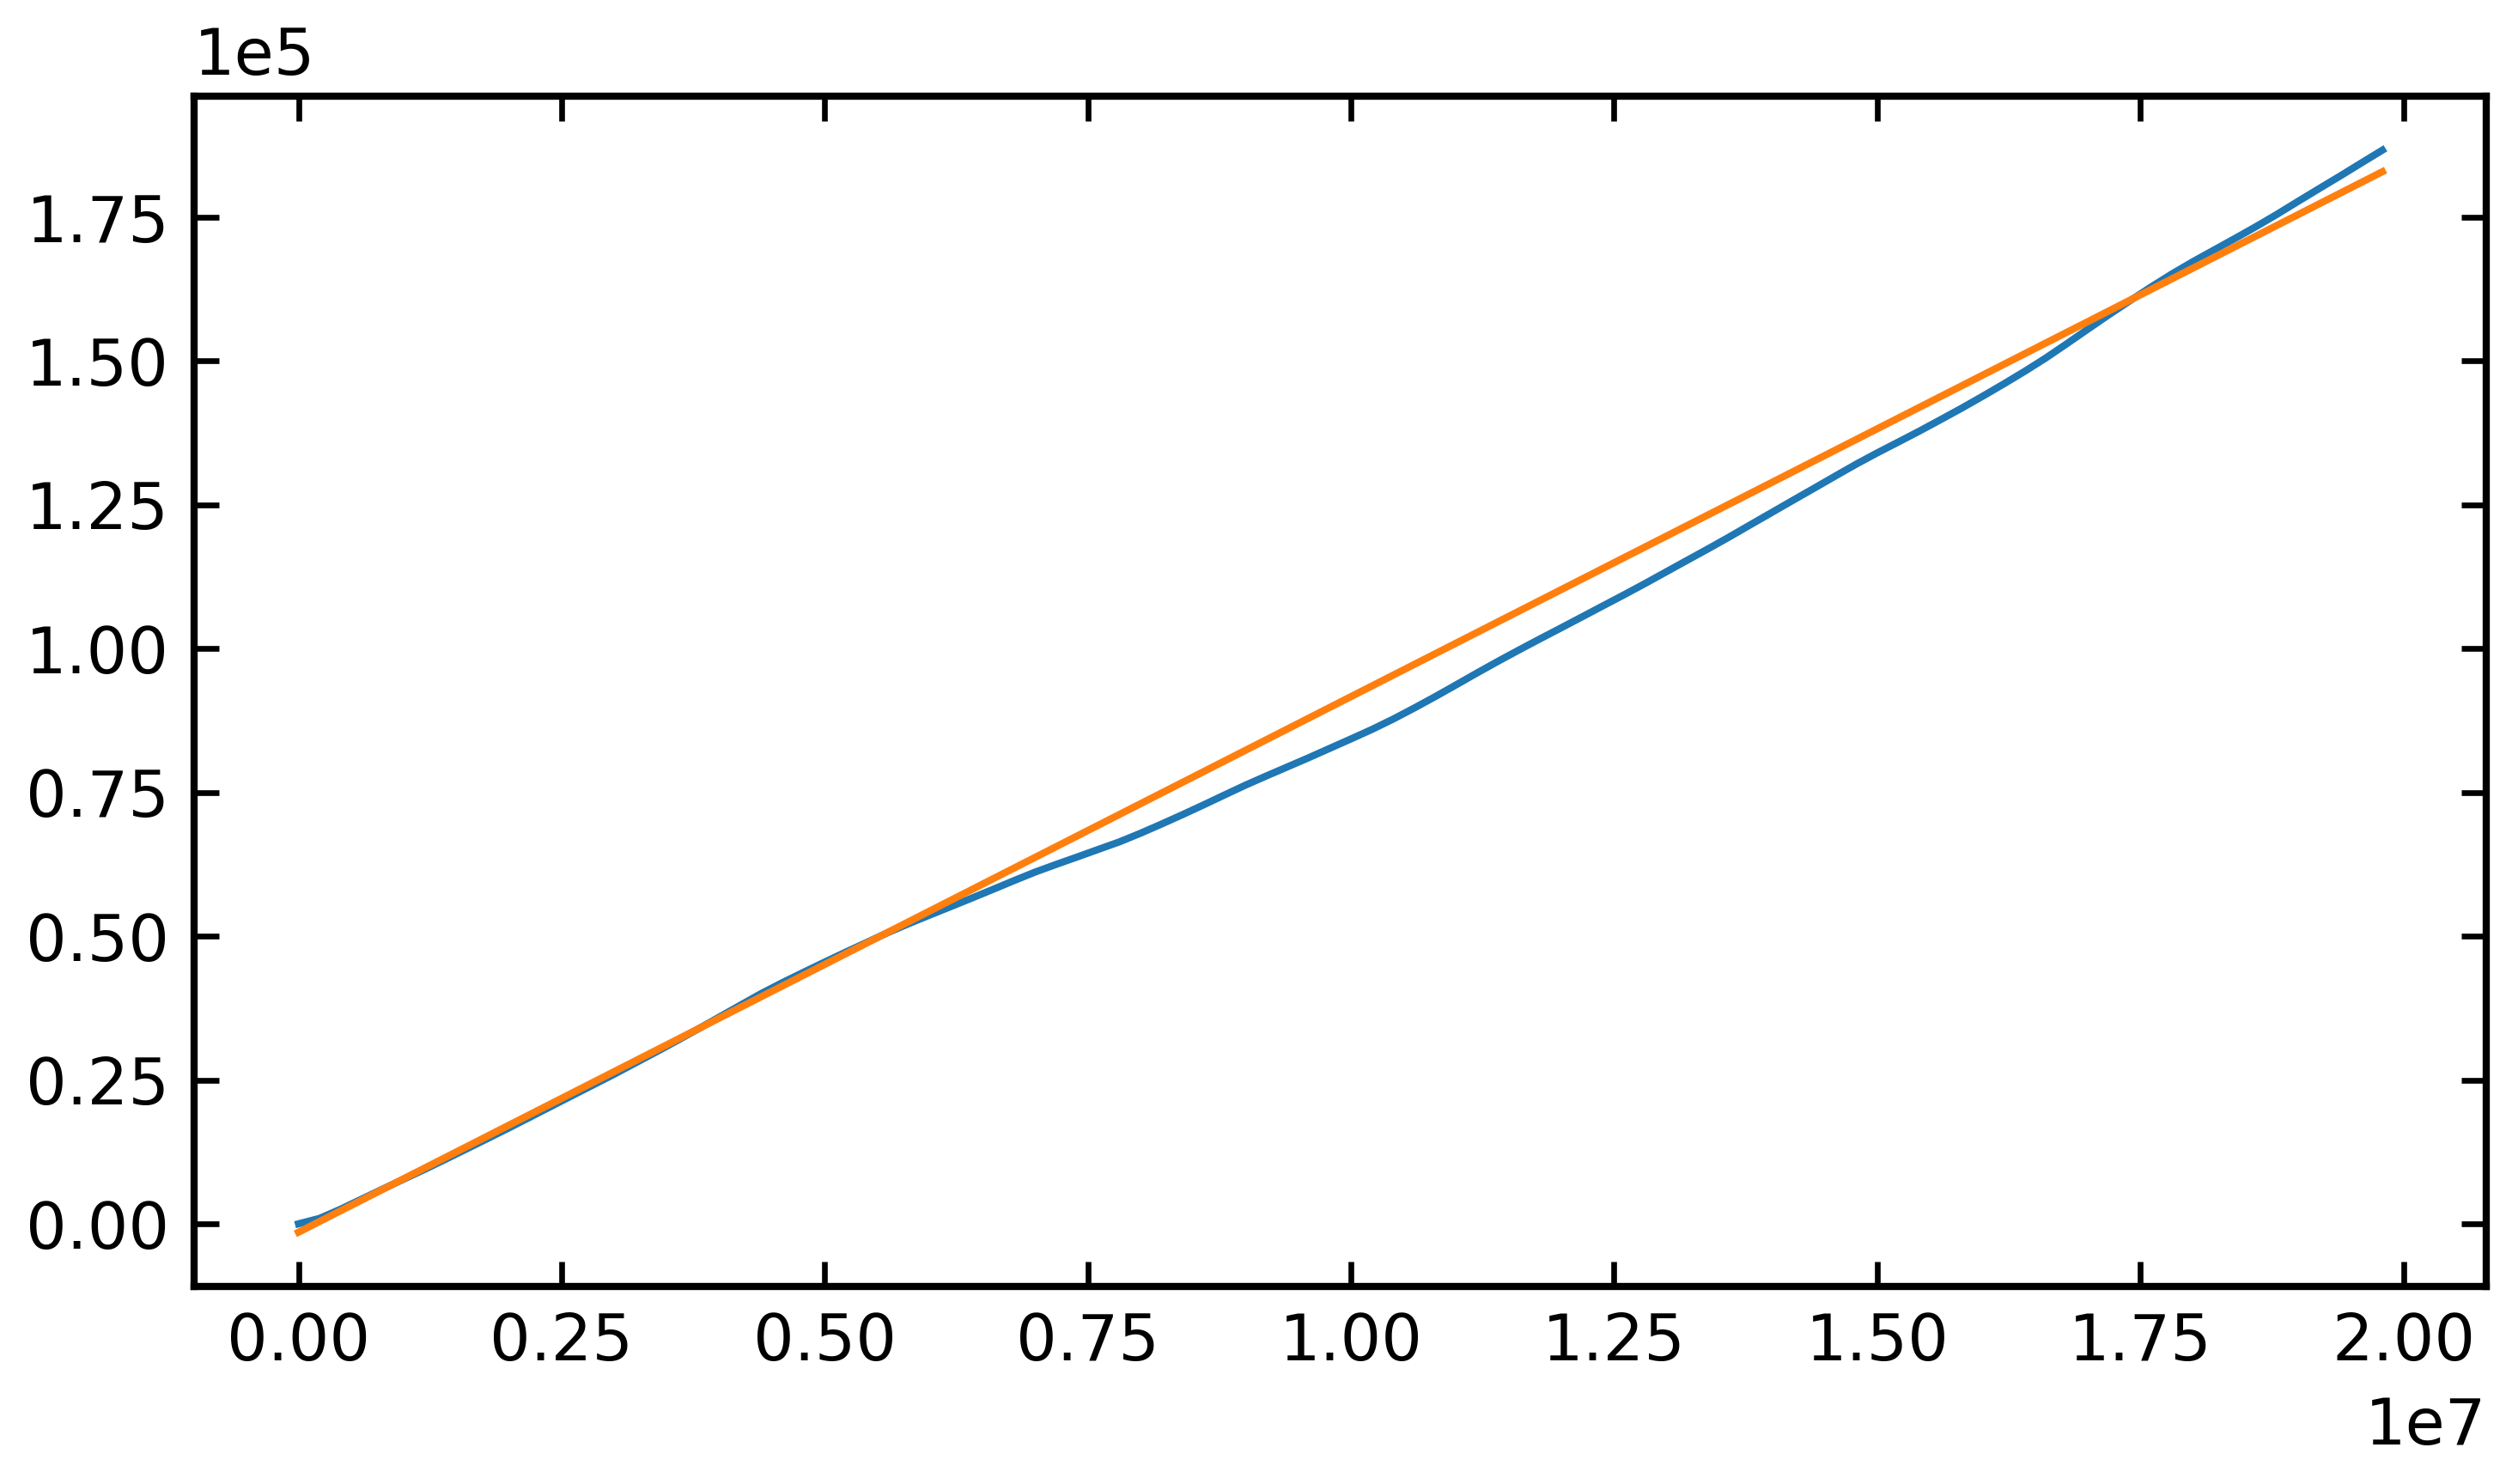

In [33]:
plt.plot(dtimes[:100],msd[:100])
plt.plot(dtimes[:100], linear(dtimes[:100], *popt))
#plt.xscale('log')
#plt.yscale('log')

In [28]:
popt, np.sqrt(pcov.diagonal())

(array([ 9.24003880e-03, -3.33066868e+03]),
 array([5.50520663e-05, 6.30916865e+02]))

In [12]:
dtimes, rg = hpa.util.compute_radius_of_gyration_from_gsd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_centered.gsd')

In [13]:
np.mean(rg), np.std(rg)/np.sqrt(len(dtimes)-1)

(2.9585966079235075, 0.03278226613549391)

# Compute concentrations in equilibruim

In [7]:
def compute_density_profile(gsd_file, axis=2, nbins=100, group=None):
    """
    Compute the density profile along a specified axis for a centered trajectory.

    Parameters
    ----------
    gsd_file : str
        Path to the GSD trajectory file.
    axis : int
        Axis along which to compute the profile: 0=x, 1=y, 2=z.
    nbins : int
        Number of bins along the axis.
    group : list of int or None
        Particle indices to include. If None, include all particles.

    Returns
    -------
    bin_centers : np.ndarray
        Center coordinates of bins along the axis.
    density : np.ndarray
        Average particle density in each bin.
    """
    traj = gsd.hoomd.open(gsd_file, 'rb')
    n_particles = traj[0].particles.N

    if group is None:
        group = np.arange(n_particles)
    else:
        group = np.array(group)

    # Collect all positions along the chosen axis
    positions = []
    for frame in traj:
        pos = frame.particles.position[group, axis]
        positions.append(pos)
    positions = np.concatenate(positions)  # all frames

    # Determine bin edges
    zmin, zmax = positions.min(), positions.max()
    bins = np.linspace(zmin, zmax, nbins + 1)

    # Compute histogram
    counts, edges = np.histogram(positions, bins=bins)

    # Convert to density: counts per bin volume
    bin_width = edges[1] - edges[0]
    # For a 1D profile along axis, volume = bin_width * box area perpendicular
    # Approximate box area using first frame
    box = traj[0].configuration.box[:3]
    if axis == 0:
        area = box[1] * box[2]
    elif axis == 1:
        area = box[0] * box[2]
    else:
        area = box[0] * box[1]

    density = counts / (len(traj) * area * bin_width)  # average over frames
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    return bin_centers, density

In [154]:
bin_centers, density = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [155]:
bin_centers_tdp, density_tdp = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800, group=[i for i in range(30800)])


In [156]:
bin_centers_ck1d, density_ck1d = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=200, group=[i for i in range(30800,30800+292+292)])


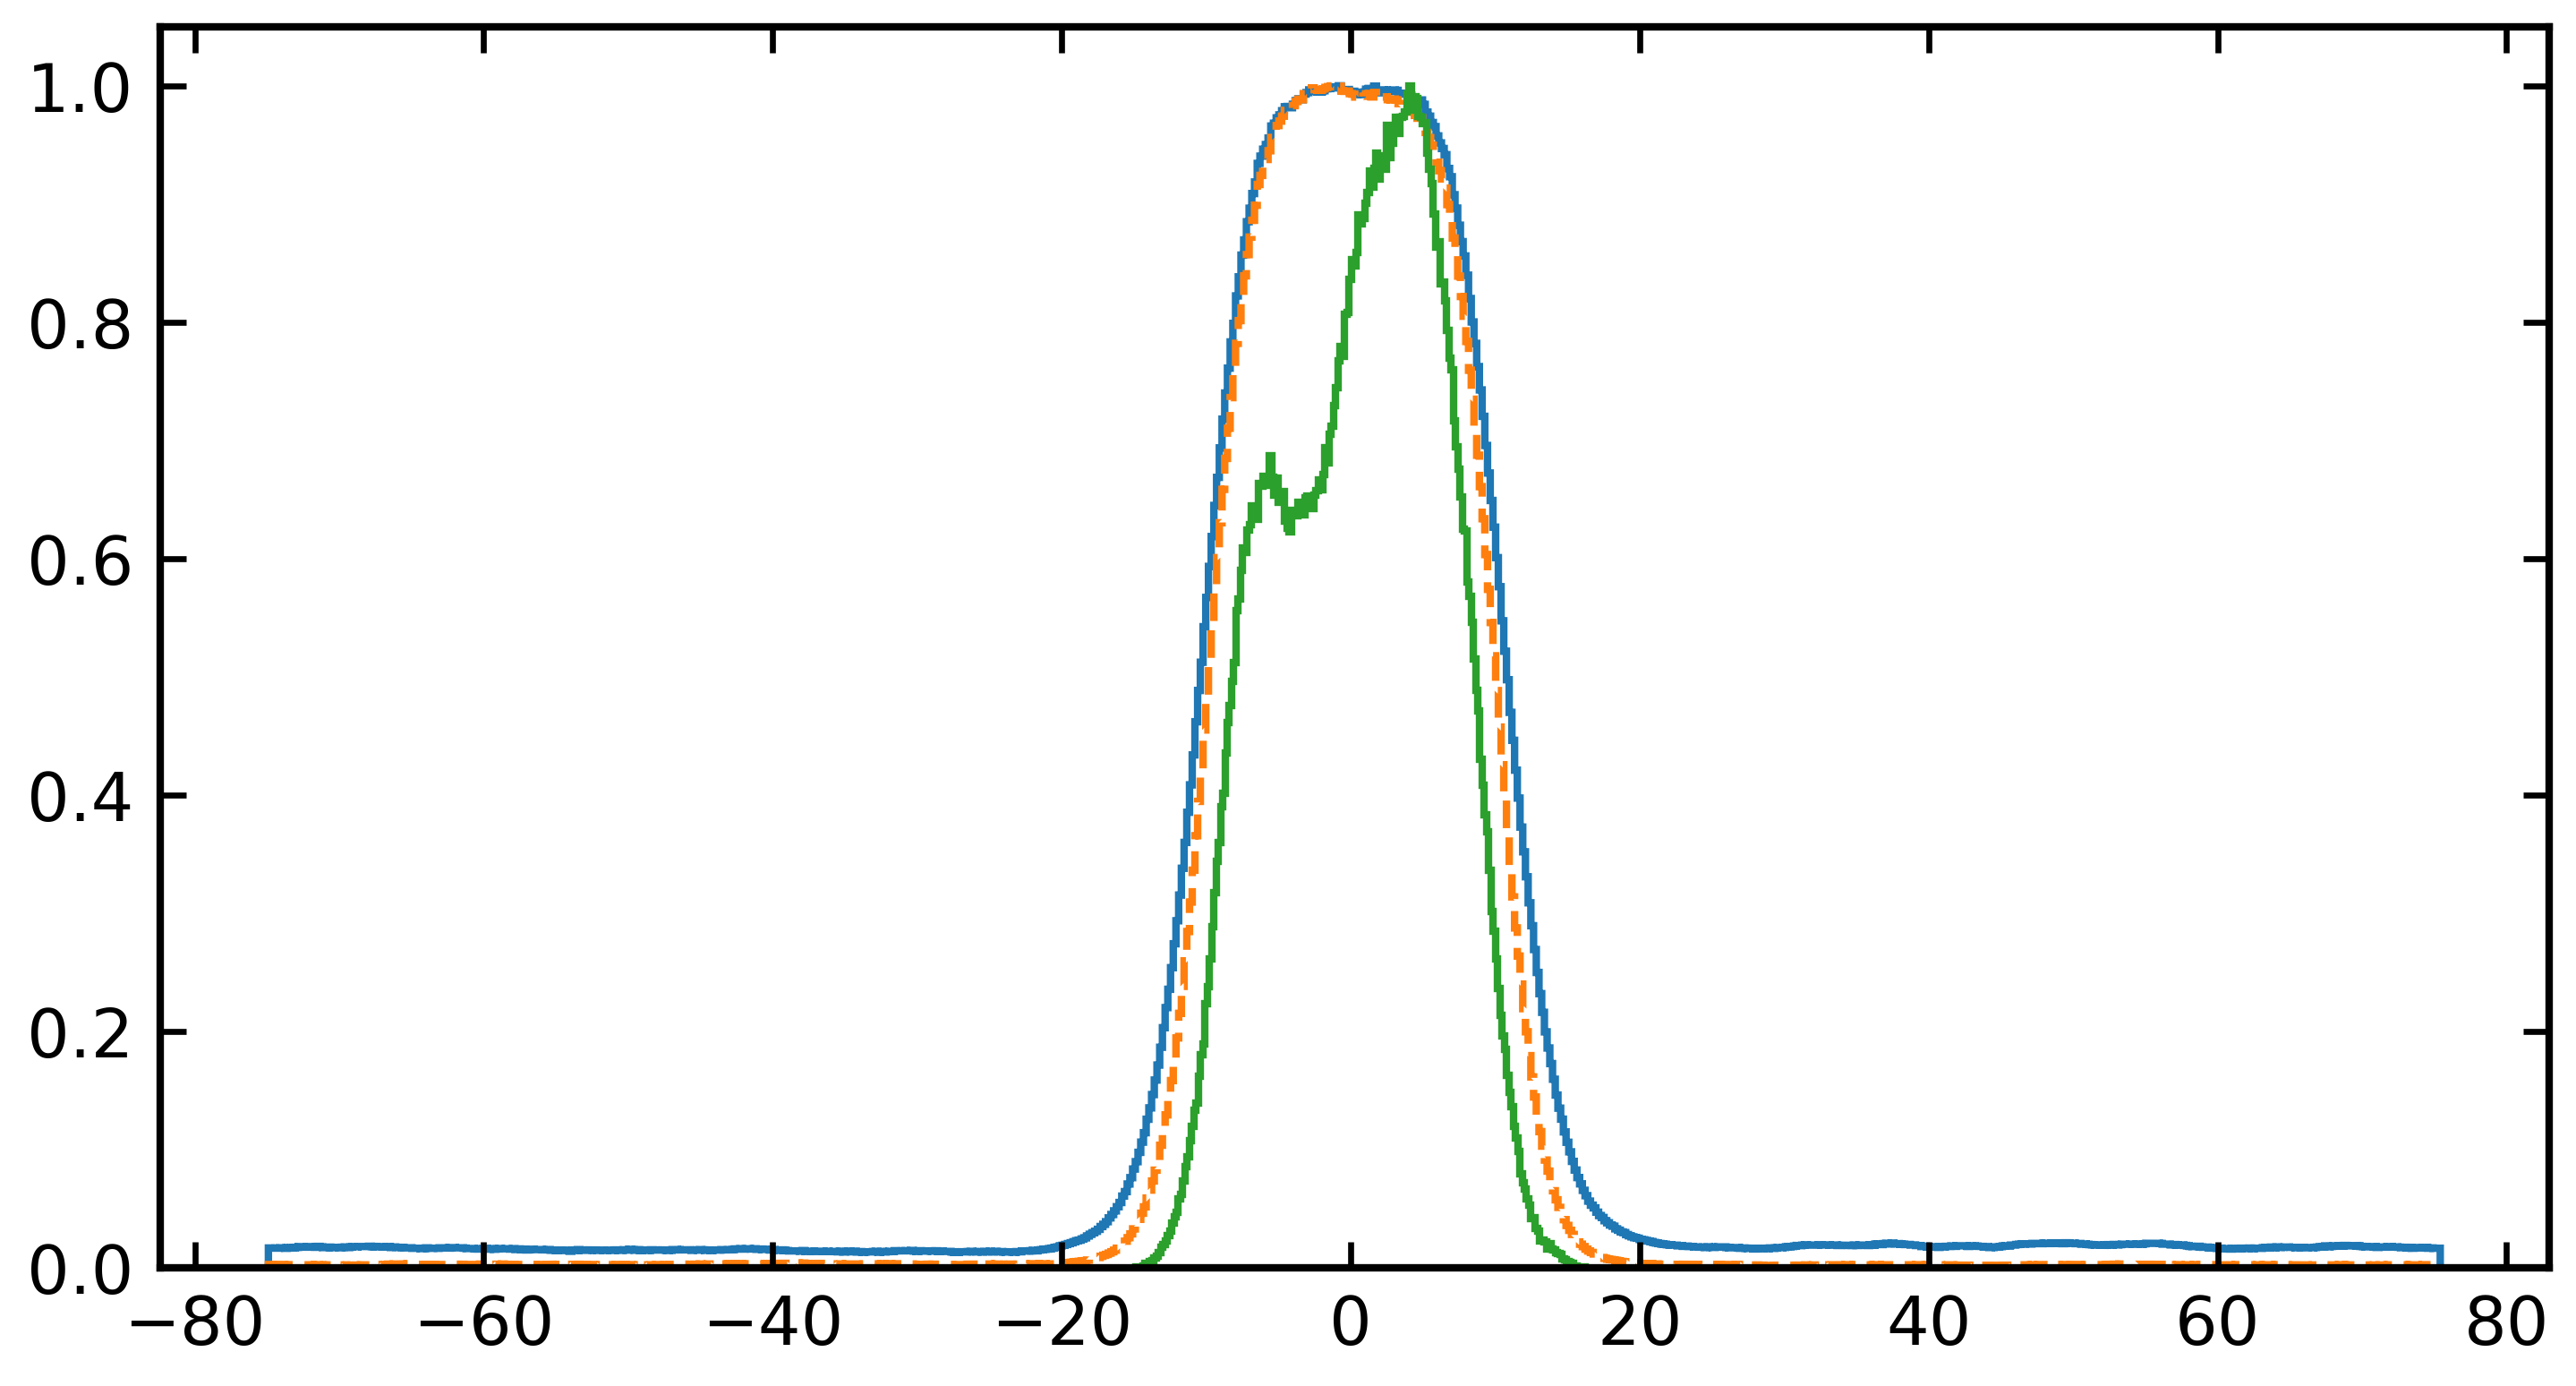

In [157]:
plt.stairs(density/np.max(density), np.append(bin_centers,bin_centers[-1]+0.5))
plt.stairs(density_tdp/np.max(density_tdp), np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5), ls='--')
plt.stairs(density_ck1d/np.max(density_ck1d), np.append(bin_centers_ck1d,bin_centers_ck1d[-1]+0.5))

In [158]:
def tanh_general(x,a,b,c,d):
    return a+b*np.tanh(c*(x-d))

In [159]:
popt_r, pcov_r = curve_fit(tanh_general, bin_centers_tdp[int(len(bin_centers_tdp)/2):], density_tdp[int(len(bin_centers_tdp)/2):], p0=[1.5, -1.49, 0.21, 8])
popt_l, pcov_l = curve_fit(tanh_general, bin_centers_tdp[:int(len(bin_centers_tdp)/2)], density_tdp[:int(len(bin_centers_tdp)/2)], p0=[1.5, 1.5, 0.21, -8])

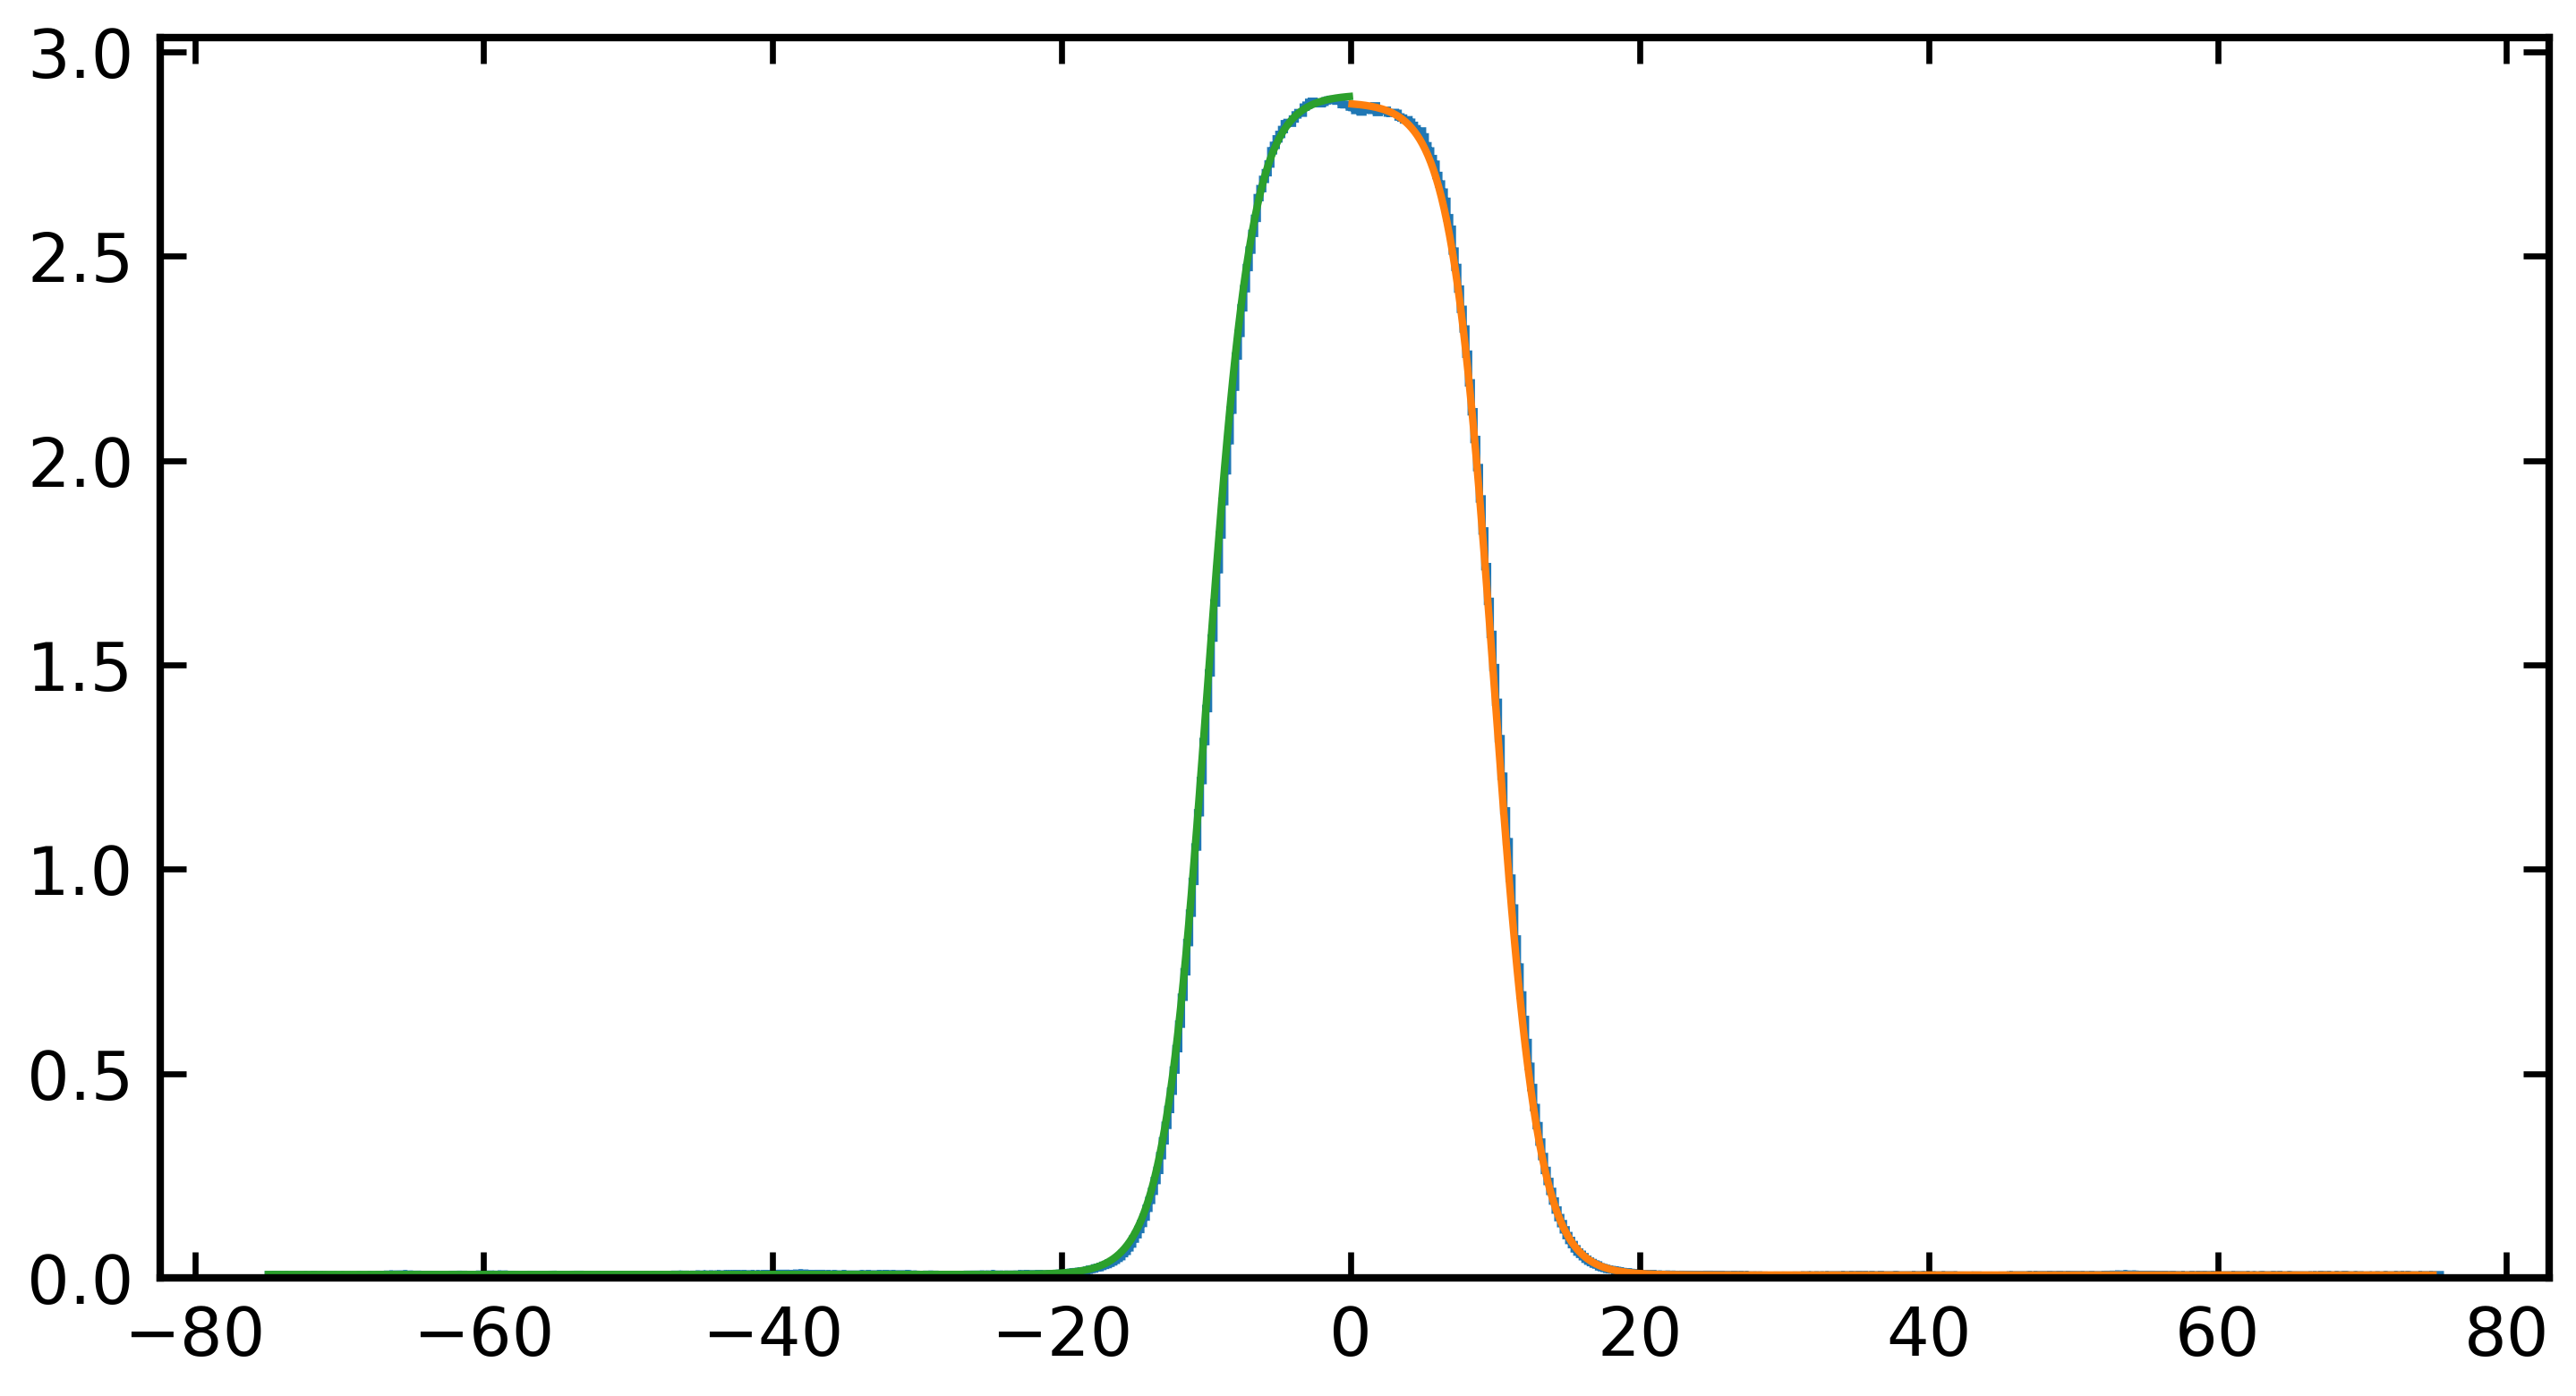

In [160]:
plt.stairs(density_tdp, np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5))
plt.plot( bin_centers_tdp[int(len(bin_centers_tdp)/2):], tanh_general(bin_centers_tdp[int(len(bin_centers_tdp)/2):], *popt_r) )
plt.plot( bin_centers_tdp[:int(len(bin_centers_tdp)/2)], tanh_general(bin_centers_tdp[:int(len(bin_centers_tdp)/2)], *popt_l) )


In [161]:
c0_in = (popt_r[0]+np.abs(popt_r[1]) + popt_l[0]+np.abs(popt_l[1]))/2
c0_in

2.8859140926811824

In [162]:
c0_out = (popt_r[0]-np.abs(popt_r[1]) + popt_l[0]-np.abs(popt_l[1]))/2
c0_out

0.007226480664372259

In [163]:
w = (1/popt_r[2] + 1/popt_l[2])/2
w

3.0291246772039377

## Cluster sizes and phospho rates

In [5]:
times_ss = np.arange(0,2500,20)
times_ss

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520,
       1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740,
       1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960,
       1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180,
       2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400,
       2420, 2440, 2460, 2480])

In [25]:
pSer_200_2_10, d_pSer_200_2_10 = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_dump.gsd', 
                                              ser_l=ser_i, n_sims=1, times=times_ss, len_prot=154, n_prot=200)

pSer_200_2_10_5us, d_pSer_200_2_10_5us = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_5us_dump.gsd', 
                                              ser_l=ser_i, n_sims=1, times=times_ss[:62], len_prot=154, n_prot=200)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
100%|███████████████████████████████████████████| 62/62 [00:01<00:00, 52.33it/s]


In [26]:
dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/'
file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_'

In [12]:
n_chains_arr = np.zeros((len(times_ss)+int(len(times_ss)/2),200))
with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr[i] = tmp_nc_5ck1d

with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'5us_dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for j, tt in enumerate(tqdm(times_ss[:int(len(times_ss)/2)])):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr[i+j] = tmp_nc_5ck1d

2500


100%|█████████████████████████████████████████| 125/125 [00:13<00:00,  9.50it/s]


1250


100%|███████████████████████████████████████████| 62/62 [00:07<00:00,  7.76it/s]


In [19]:
condensate_size_t = np.max(n_chains_arr, axis=1)

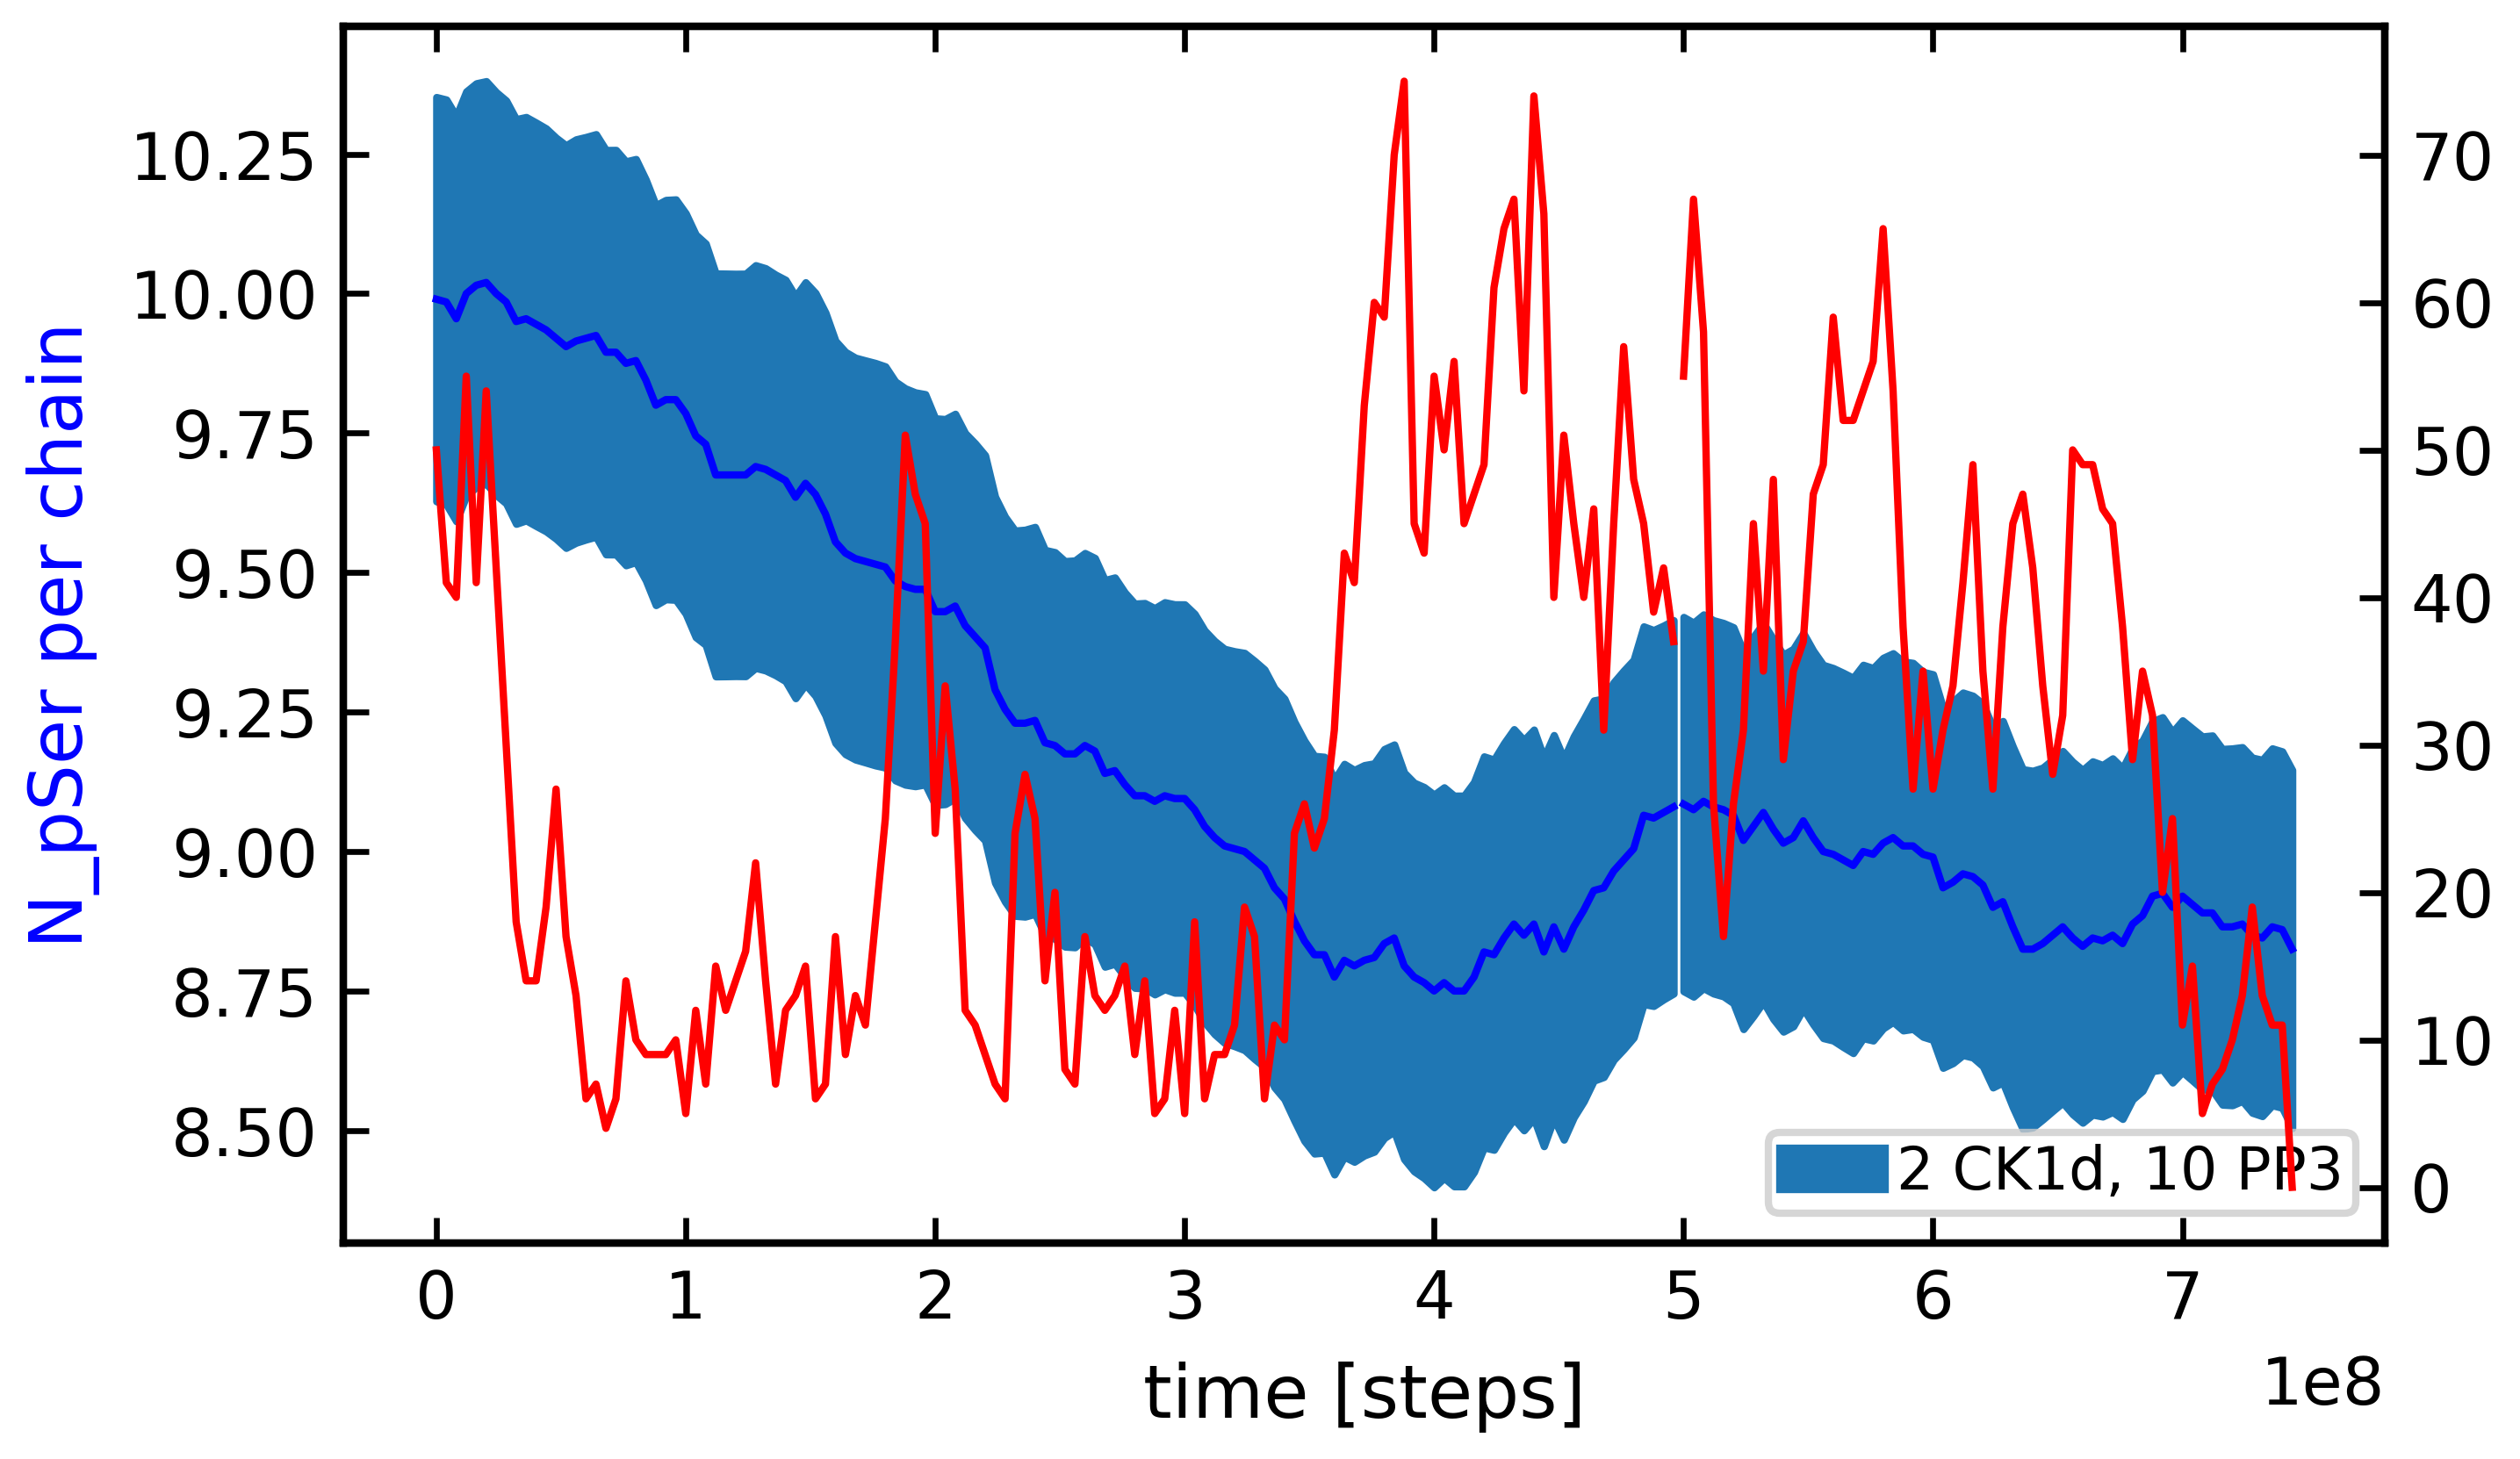

In [28]:
time_step_ss = times_ss*200000 

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot the first array with the primary y-axis
ax1.plot(time_step_ss, pSer_200_2_10, 'b')
ax1.fill_between(time_step_ss, pSer_200_2_10-d_pSer_200_2_10, pSer_200_2_10+d_pSer_200_2_10, color='tab:blue', label='2 CK1d, 10 PP3')
ax1.plot(time_step_ss[:62]+5*10e7, pSer_200_2_10_5us, 'b')
ax1.fill_between(time_step_ss[:62]+5*10e7, pSer_200_2_10_5us-d_pSer_200_2_10_5us, pSer_200_2_10_5us+d_pSer_200_2_10_5us, color='tab:blue')

ax1.set_xlabel('time [steps]')
ax1.set_ylabel('N_pSer per chain', color='b')

ax2 = ax1.twinx()
ax2.plot(time_step_ss, condensate_size_t[:125], 'r')
ax2.plot(time_step_ss[:62]+5*10e7, condensate_size_t[125:], 'r')

#ax1.set_ylim(3,5)
#ax1.set_xlim(2*1e8,10*1e8)
ax1.legend(ncols=2, loc='lower right')
#filename = '/localscratch/zippoema/project_ness/plots/2-tdp43-lcd_1-ck1d-open_1-pp3/n_pser_in_time_20-tdp43'
#plt.savefig(filename+'.png', dpi=600)
#plt.savefig(filename+'.pdf', dpi=600)

(array([101.,  19.,   6.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14.]),
 <BarContainer object of 13 artists>)

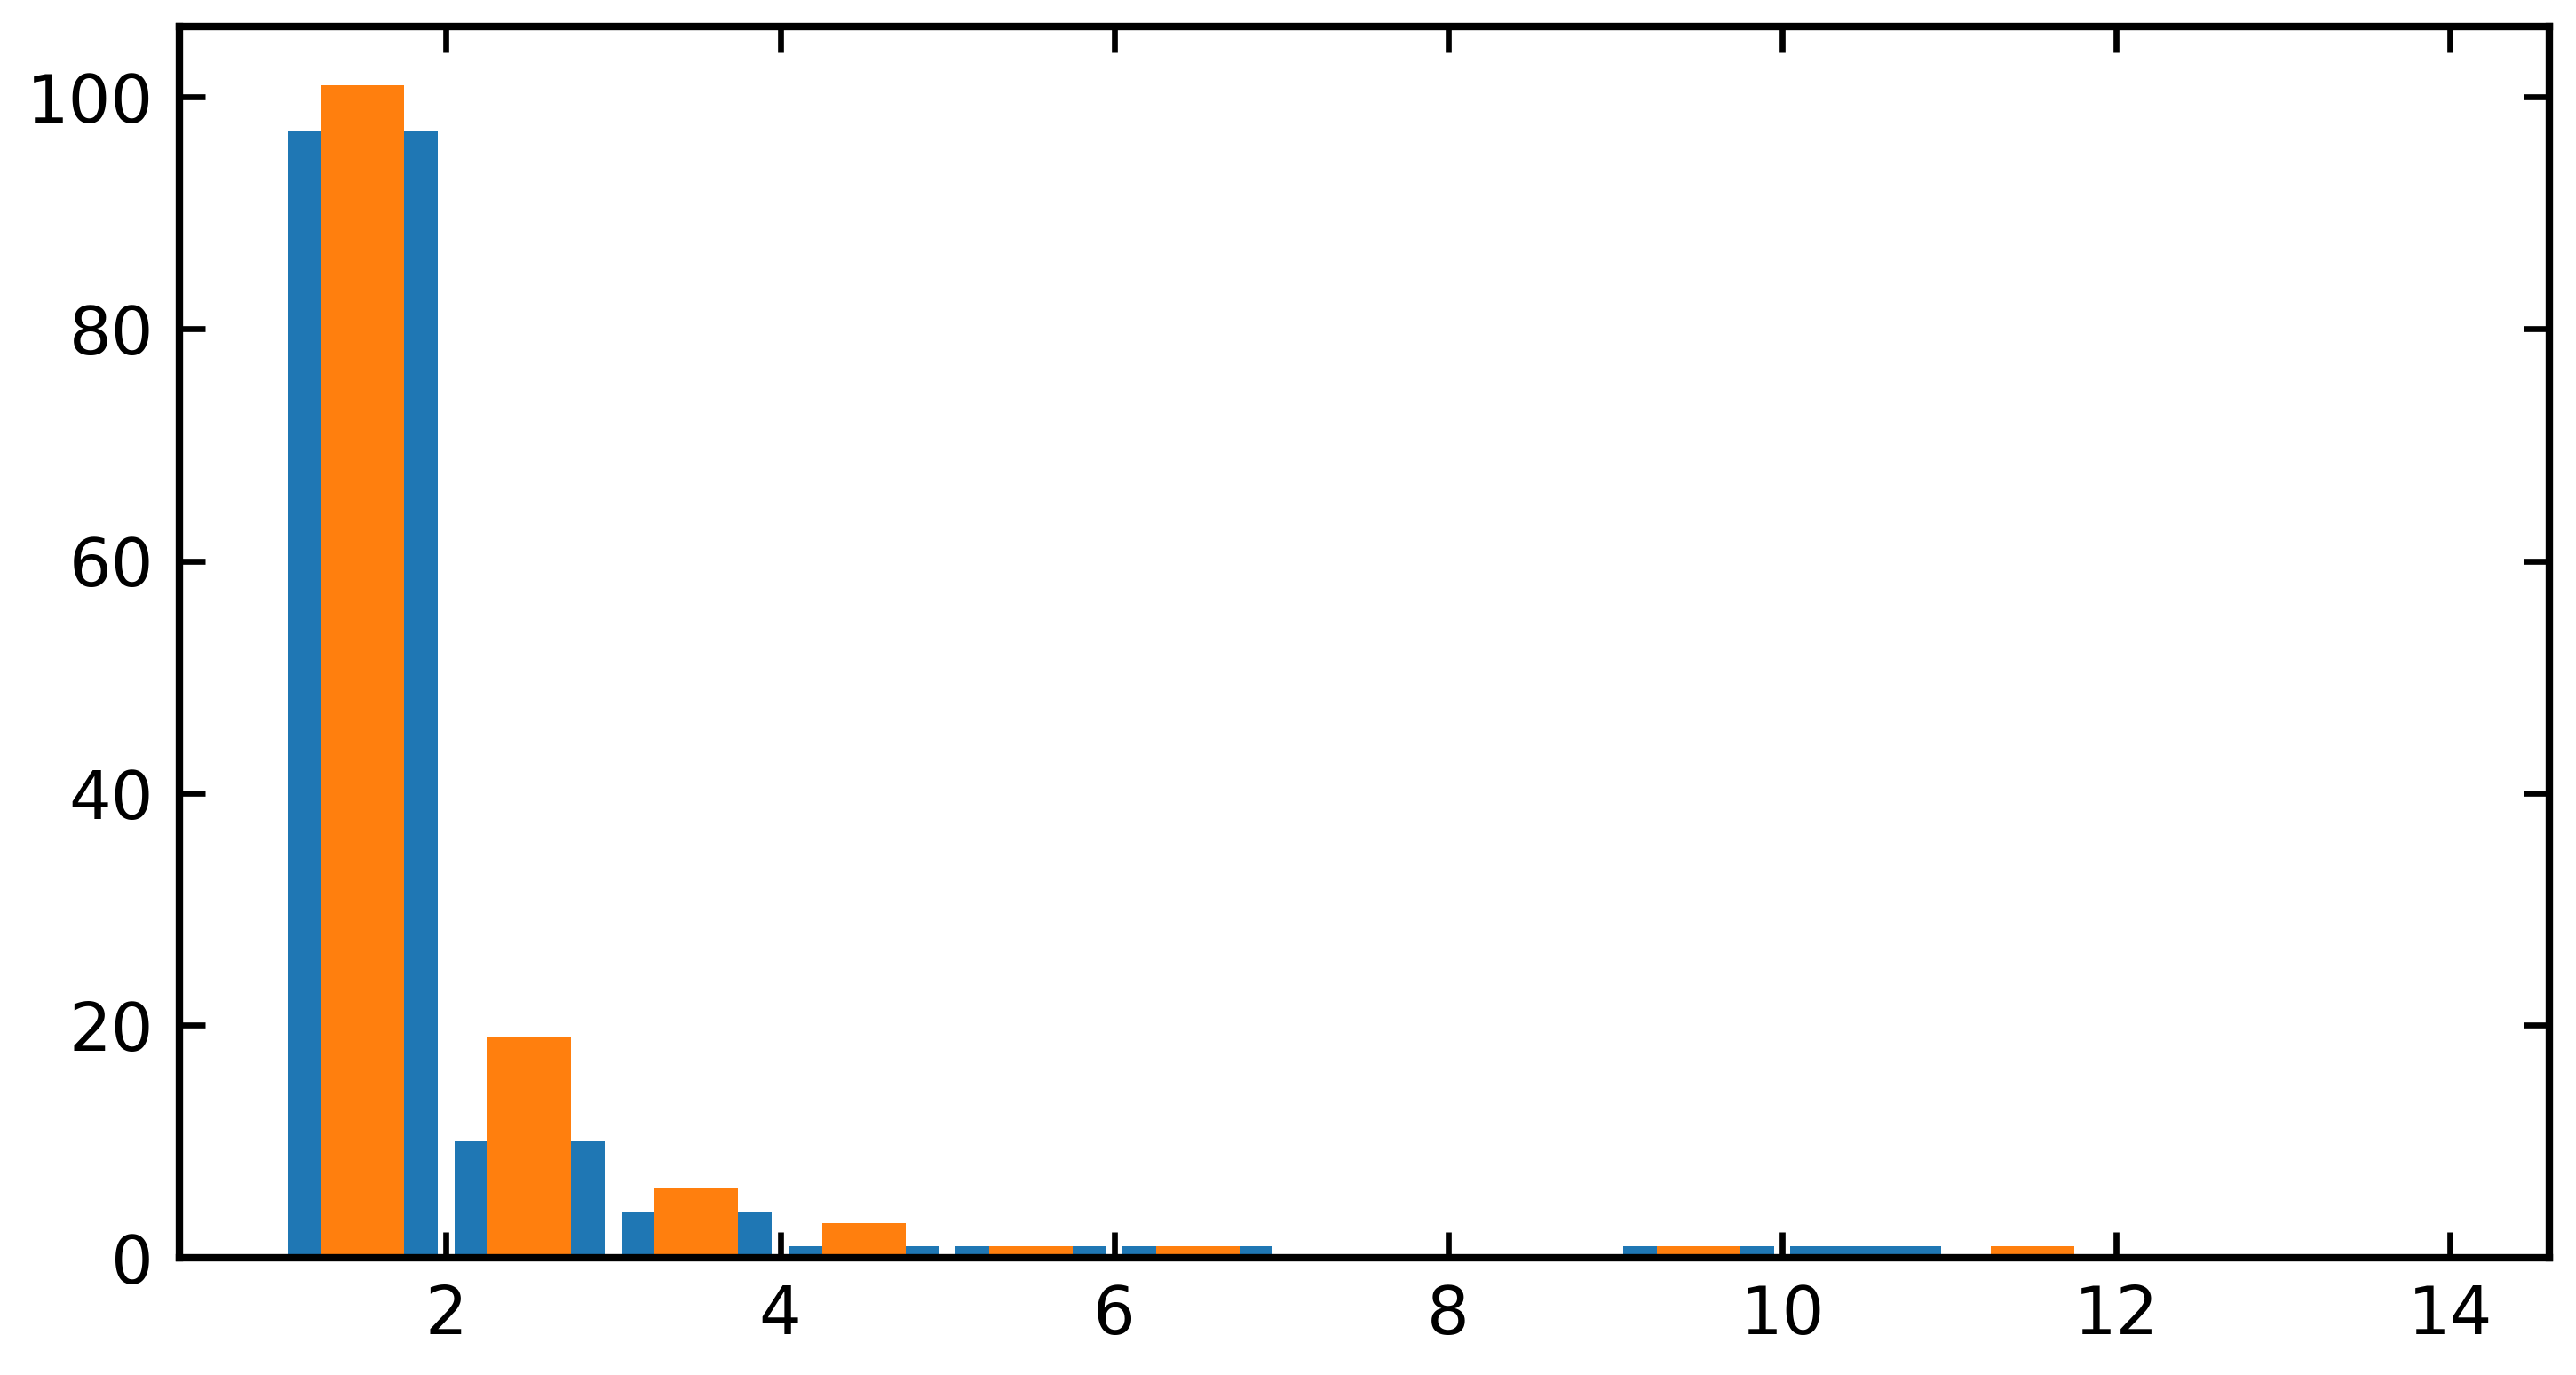

In [44]:
plt.figure()
plt.hist(n_chains_arr[124], bins=list(np.arange(1,15)), rwidth=0.9)
plt.hist(n_chains_arr[185], bins=list(np.arange(1,15)), rwidth=0.5)

In [37]:
n_chains_arr[120]

array([ 3.,  1.,  5.,  1.,  1.,  1.,  1.,  1.,  1., 48.,  5.,  1.,  1.,
        2.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        2.,  4.,  1.,  2.,  4.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,
        1.,  2.,  2.,  2.,  1.,  1.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  4.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,
        2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0